[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/Fashion_Articles_with_CNN.ipynb)

# Recognising Fashion Articles with Convolution Neural Network (CNN)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphs

from keras.datasets import fashion_mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [18]:
# load the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(f'''Shapes
X_train: {X_train.shape};\ty_train: {y_train.shape}
X_test: {X_test.shape};\ty_test: {y_test.shape}''')


# reshape and normalise the data

X_train = X_train.reshape(-1, 28, 28, 1) / 255
y_train = to_categorical(y_train)

X_test = X_test.reshape(-1, 28, 28, 1) / 255
y_test = to_categorical(y_test)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Shapes
X_train: (60000, 28, 28);	y_train: (60000,)
X_test: (10000, 28, 28);	y_test: (10000,)


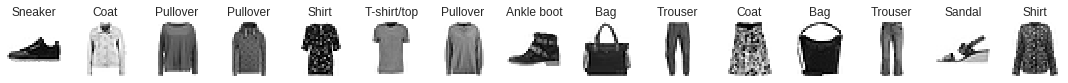

In [5]:
# check out some random images
plt.figure(figsize=(15, 2))
for i, n in enumerate(np.random.choice(range(60000), 15)):
    plt.subplot(1, 15, i + 1)
    plt.imshow(X_train[n].reshape(28, 28), cmap='binary')
    plt.xticks(())
    plt.yticks(())
    plt.title(labels[np.argmax(y_train[n])])

plt.tight_layout()

In [0]:
def train(model, n = 5, callbacks = [EarlyStopping(patience=3, verbose=1)], verbose=0):
    # given a model, train it for n times and plot the associated metrics
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # during optimisation, found that rmsprop works better than sgd
    model.summary()
    initial_weights = model.get_weights() # save the initial weights
    
    hists = [] # contains all the history
    
    plt.figure(figsize=(4 * (n + 2), 8)) # the figure

    for i in range(n):
        hist = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_test,y_test), callbacks=callbacks, verbose=verbose)
        model.set_weights(initial_weights) # restore its initial weights so it can be trained in the next loop
        hists.append(hist)

        r = range(2, len(hist.history['acc']) + 1) # starting from epoch 2, ignore the first epoch
        plt.subplot(2, n + 1, i + 2) # plot the loss history, starting with subplot 3
        plt.plot(r, hist.history['loss'][1:], '.-', label='Train loss') # ignore the first epoch
        plt.plot(r, hist.history['val_loss'][1:], '.-', label='Val loss')
        plt.legend()
        
        plt.subplot(2, n + 1, i + 2 + n + 1) # plot the acc history, starting with subplot 3
        plt.plot(r, hist.history['acc'][1:], '.-', label='Train acc')
        plt.plot(r, hist.history['val_acc'][1:], '.-', label='Val acc')
        plt.legend()

    
    plt.subplot(2, n + 1, 1) # plot the loss summary at the first subplot
    metrics = ['loss'] * n + ['val_loss'] * n 
    values = np.concatenate([
        [i.history['loss'][-1] for i in hists],
        [i.history['val_loss'][-1] for i in hists],
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Loss')
    values = values.reshape(2, -1)
    print('Loss', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))
    
    plt.subplot(2, n + 1, n + 2) # plot the acc summary at the second subplot
    metrics = ['acc'] * n + ['val_acc'] * n
    values = np.concatenate([
        [i.history['acc'][-1] for i in hists],
        [i.history['val_acc'][-1] for i in hists]
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Accuracy')
    values = values.reshape(2, -1)
    print('Acc', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))

    plt.tight_layout()
    
    return hists

### Trial 0

Firstly, we try with just normal neural networks with 2 hidden layers, each with 32 neurons

We got a mean accuary of 0.8812 and 0.8524 for the train and test set respectively.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_13 (Dense)             (None, 28, 28, 32)        1056      
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                250890    
Total params: 252,010
Trainable params: 252,010
Non-trainable params: 0
_________________________________________________________________
Epoch 00009: early stopping
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00011: early stopping
Loss [0.33384711 0.33314343 0.34747522 0.31545389 0.317826  ] [0.42547902 0.41390994 0.41101969 0.38520891 0.42003529]
Mean [0.3

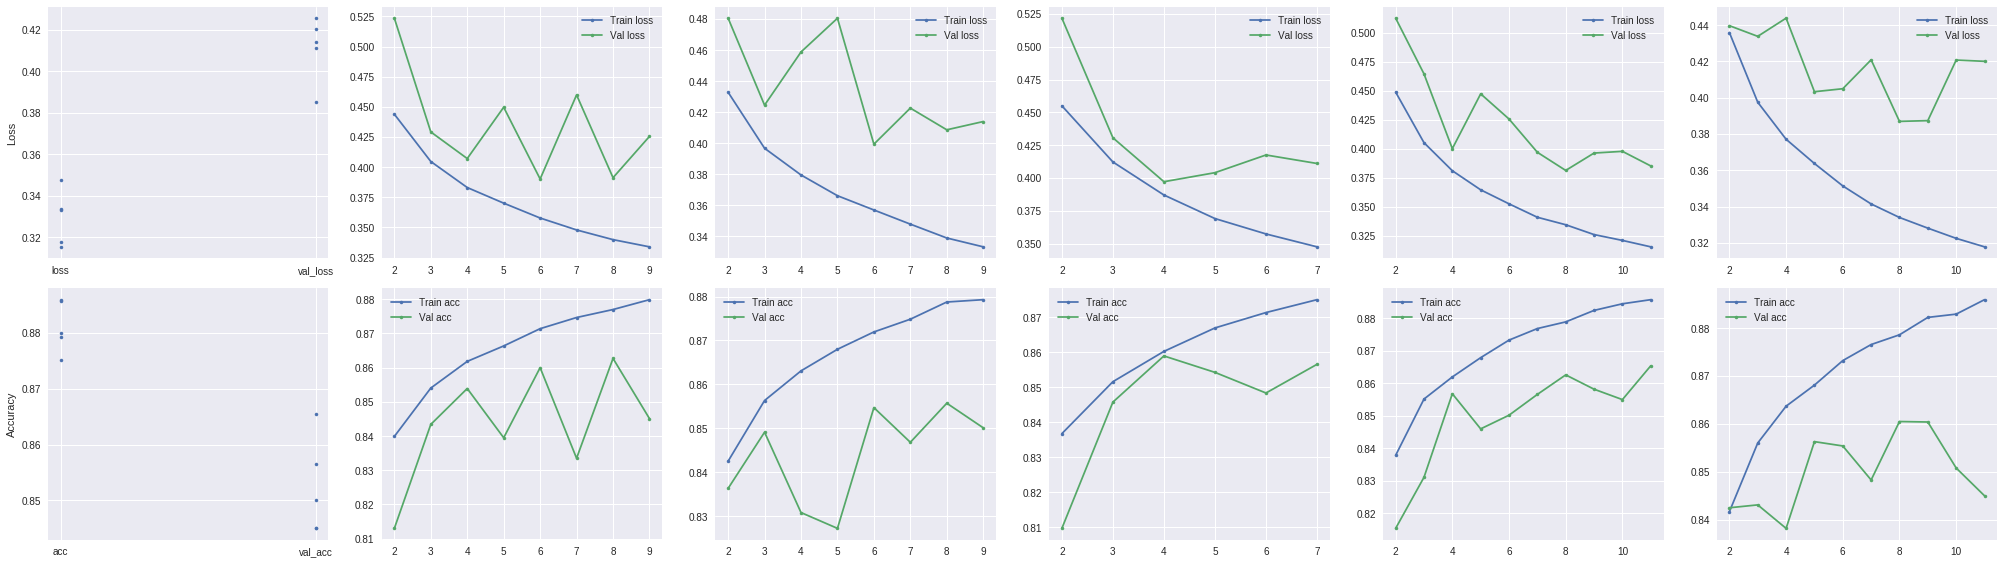

In [20]:
# Try just normal neural networks with 2 hidden layers, each with 32 neurons
%%time

model = Sequential()
model.add(Dense(32, input_shape=(28, 28, 1), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 1

Now try with the most basic Convolution network, with just 1 convolution layer with the default kernel size of 3 and stride of 1.

I find the animations in http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html explain kernel size, stride and padding very well!

We obtained a mean accuracy of 0.9313 (train) and 0.8945 (test). Much better than the normal neural network.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_12 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________
Epoch 00014: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Loss [0.17328205 0.19499018 0.18787476 0.19452123 0.22034765] [0.29018428 0.31896762 0.29186872 0.29468923 0.31407466]
Mean [0.19420318 0.3019569 ] Std [0.01524465 0.012078  ]
Acc [0.93885    0.93115    0.93345    0.93145    0.92176667] [0.9039 0.8887 0.8978 0

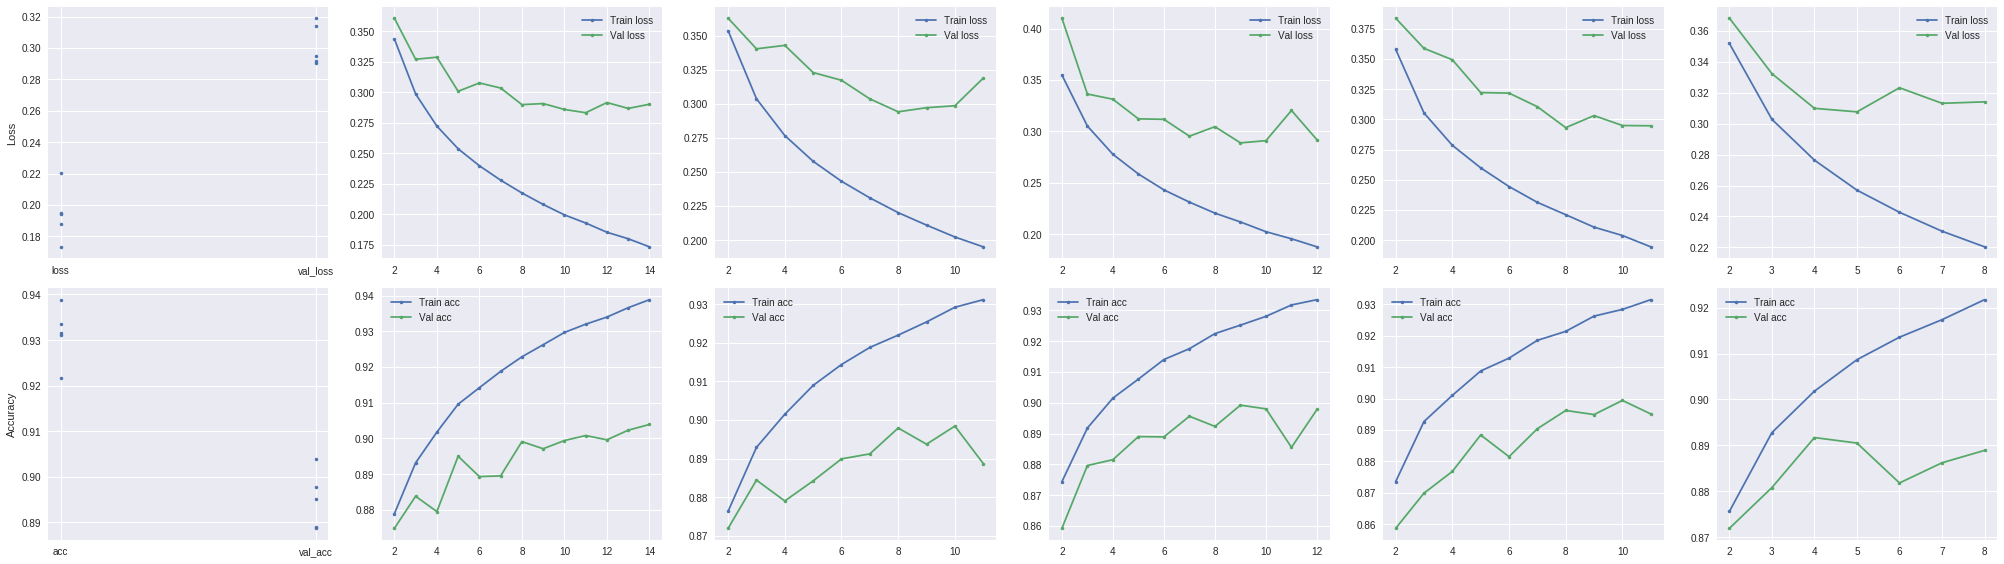

In [21]:
# now try with Convolution, the most basic

%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 2
Changed the strides to 2

It doesn't seem to improve anything

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_13 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Epoch 00028: early stopping
Epoch 00024: early stopping
Epoch 00022: early stopping
Epoch 00023: early stopping
Epoch 00013: early stopping
Loss [0.20536298 0.20939139 0.21730106 0.21053412 0.25498176] [0.32434808 0.29792229 0.31552095 0.30407464 0.32674394]
Mean [0.21951426 0.31372198] Std [0.01814506 0.01121091]
Acc [0.92776667 0.92545    0.92338333 0.92573333 0.909     ] [0.8853 0.8936 0.8874 0.8

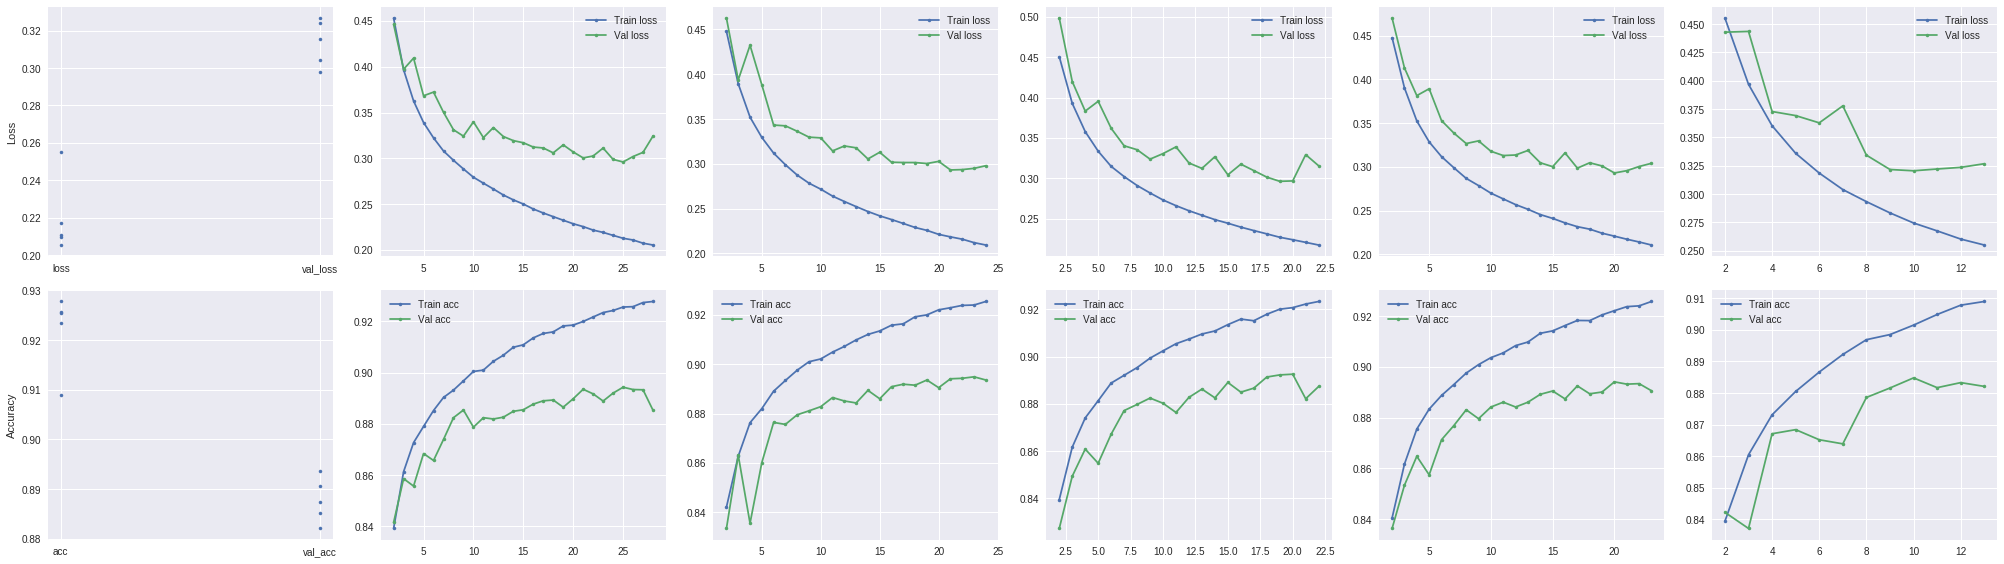

In [22]:
# increase the stride to 2
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=2, activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 3
Set the padding to "same".

It doesn't seem to improve anything either.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
flatten_31 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________
Epoch 00014: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00020: early stopping
Epoch 00014: early stopping
Loss [0.25080241 0.2313212  0.24189907 0.22126721 0.2507836 ] [0.3202025  0.31222611 0.33909668 0.30562652 0.32476935]
Mean [0.2392147  0.32038423] Std [0.01148686 0.01143471]
Acc [0.91103333 0.91881667 0.91481667 0.9219     0.91095   ] [0.8874 0.8915 0.8781 0.8

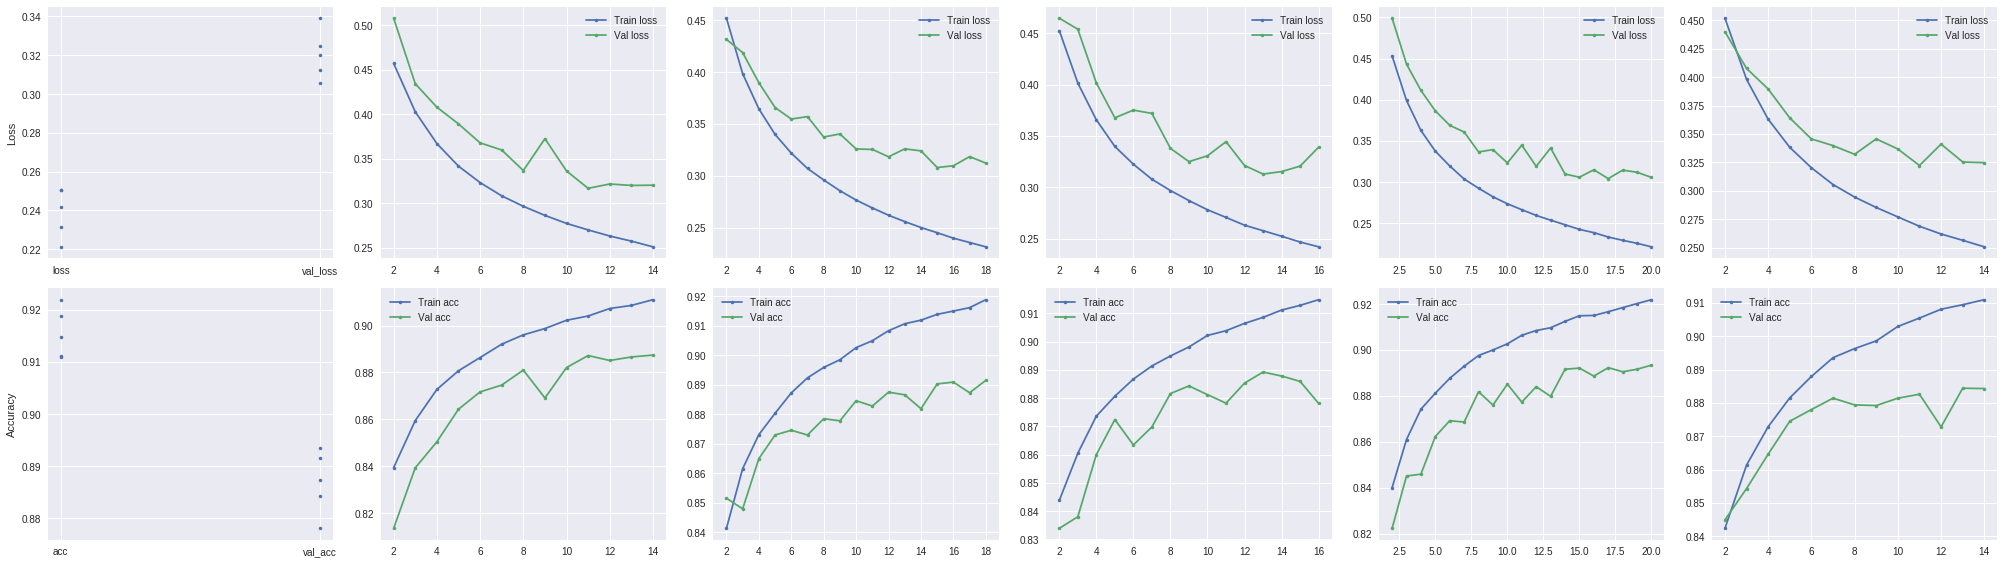

In [46]:
# set padding to 'same'
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 4
Add another Dense layer

Average accuracies have increased for both train and test set

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_32 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               2769024   
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Loss [0.12686194 0.11044483 0.11176495 0.08427913 0.11425852] [0.29156072 0.32207396 0.30249613 0.31388811 0.28691212]
Mean 

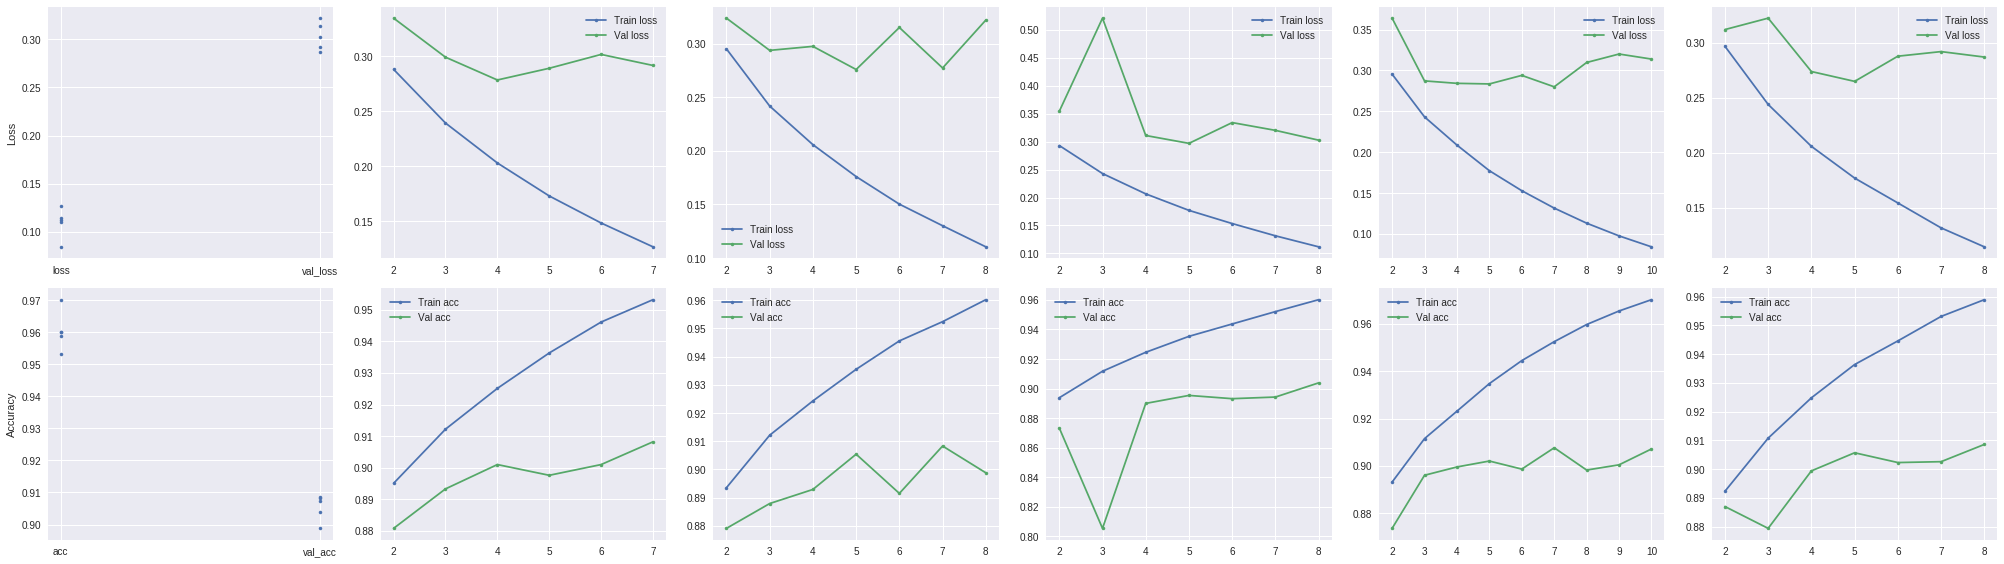

In [47]:
# Add another Dense layer

%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # I just chose 128 randomly
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 5
Increase the number of filter in the first Conv2D layer, from 32 to 64

The trainable param number is now over 5 millions!

Not a great improvement, so won't be using it.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
flatten_33 (Flatten)         (None, 43264)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               5537920   
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total params: 5,539,850
Trainable params: 5,539,850
Non-trainable params: 0
_________________________________________________________________
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00009: early stopping
Loss [0.08212663 0.10727052 0.0859035  0.09086804 0.07364564] [0.38037102 0.29732327 0.32941196 0.38115628 0.31708589]
Mean 

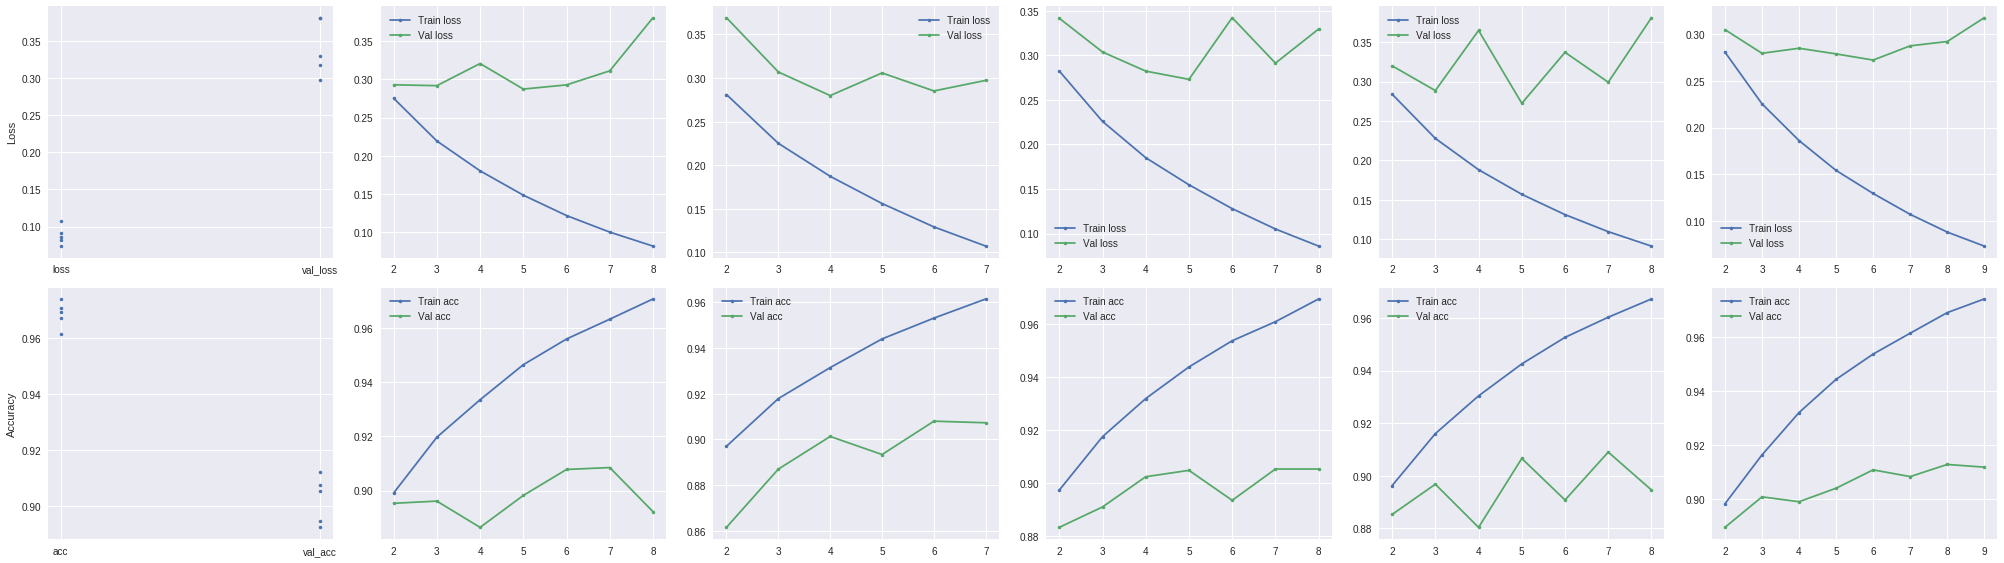

In [48]:
# more filters in the first Conv2D layer, from 32 to 64
%%time
model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 6
Add a MaxPooling.

Not too much improvement.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopp

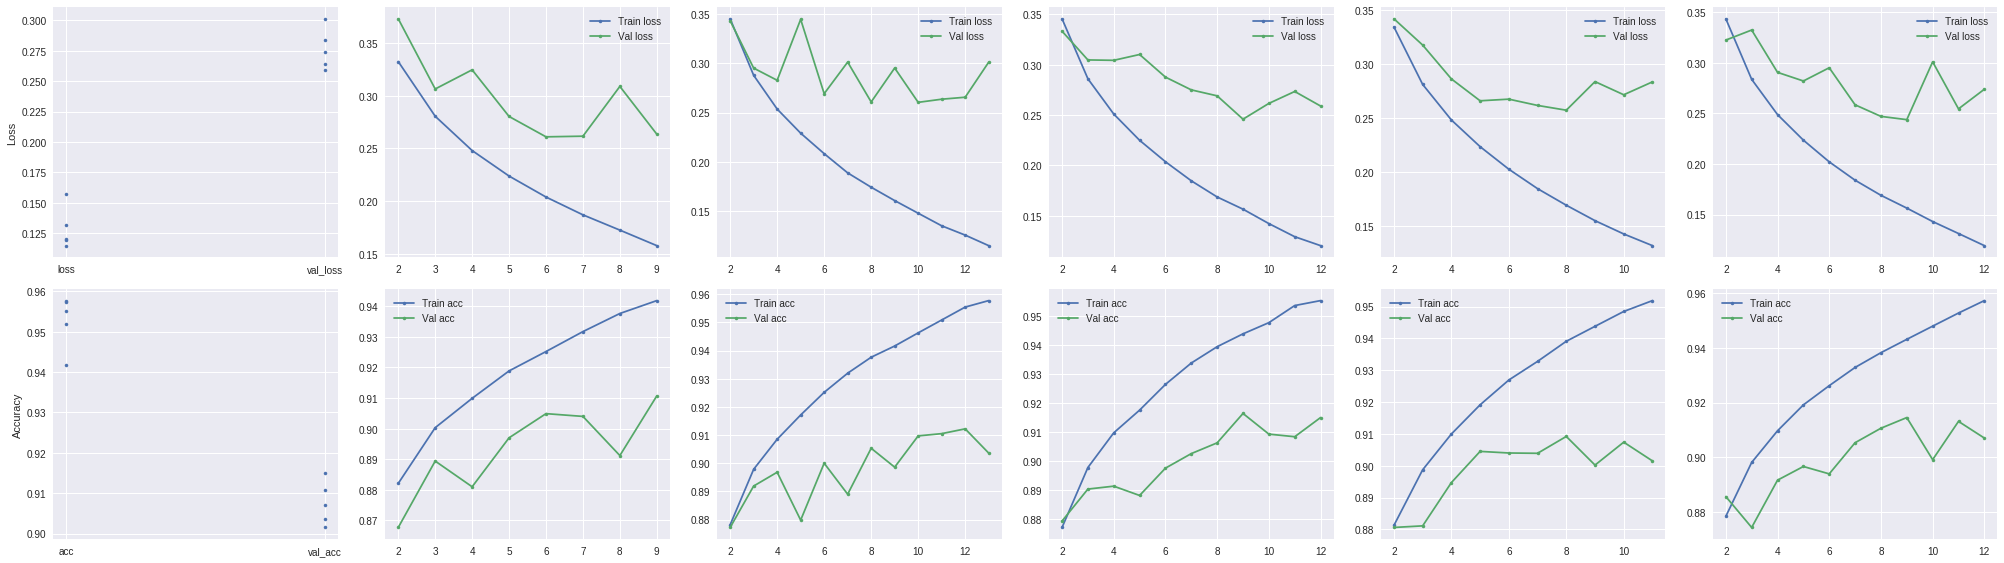

In [49]:
# add MaxPooling
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 7
Add BatchNormalization, this helps with weights and faster training.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_54 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_58 (Dense)             (None, 10)                1290      
Total para

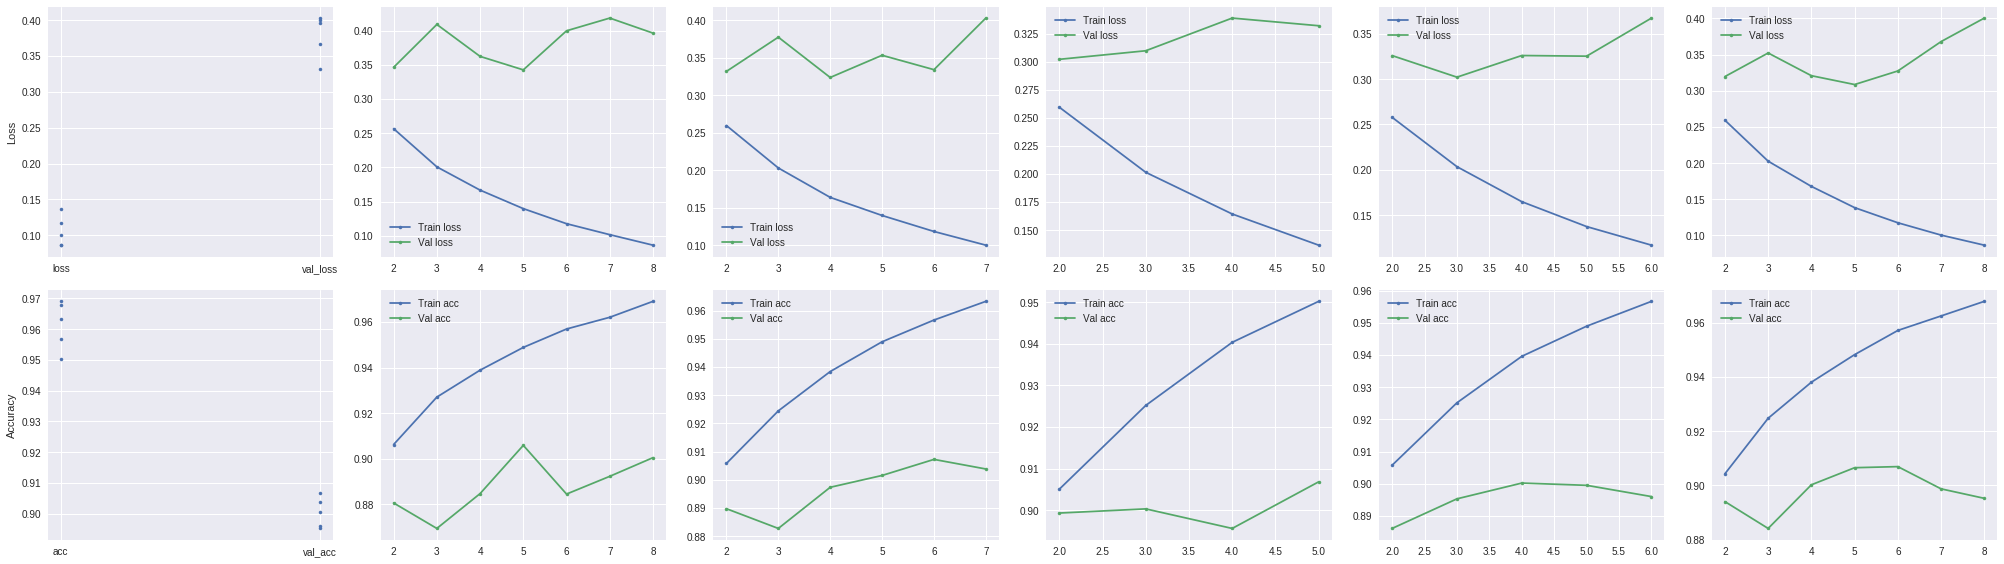

In [50]:
# add Batchnormalisation, to help with normalising weights 
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 8
Add 1 more set of Conv2D, Batch, MaxPooling

Doesn't seem to help with accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_58 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 32)          0         
__________

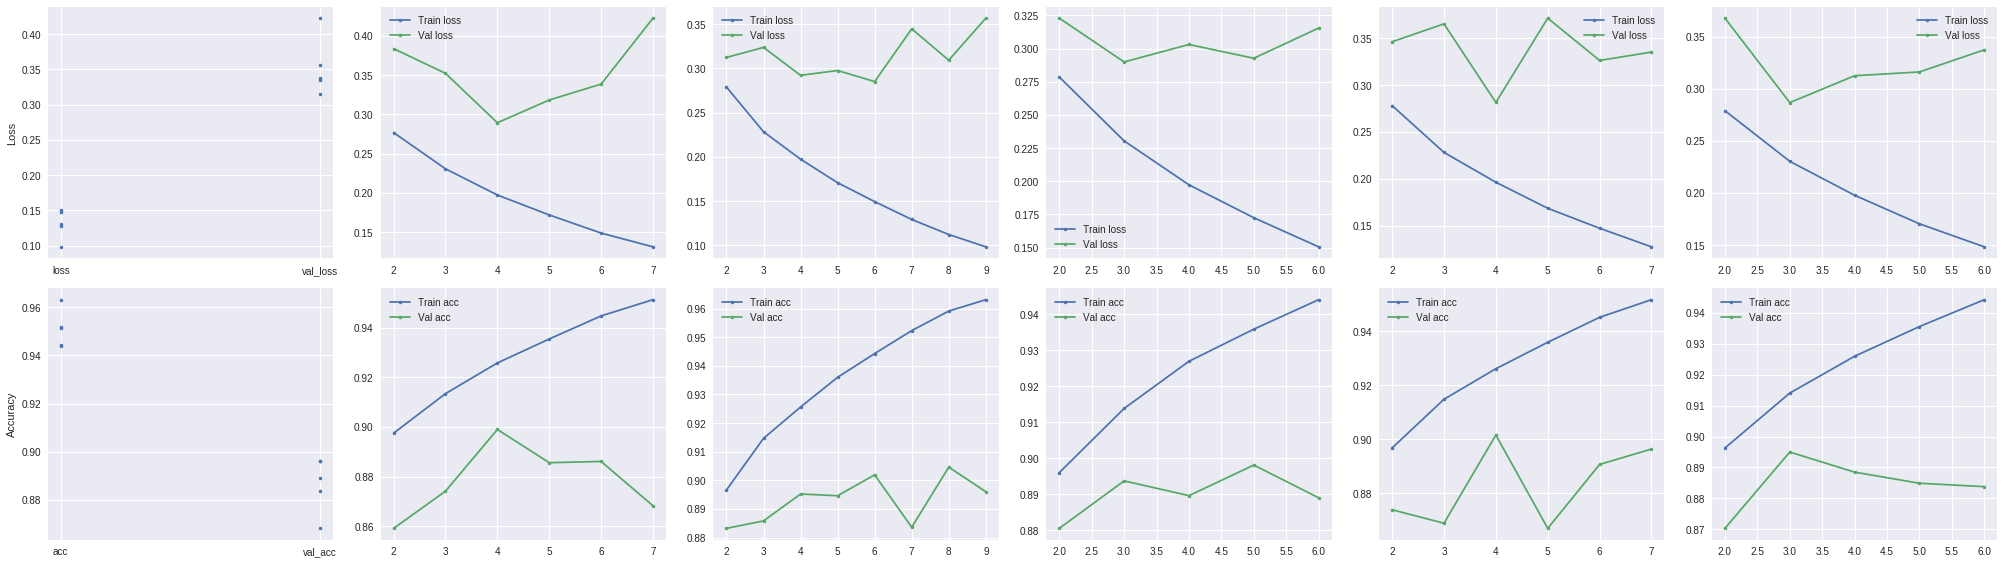

In [51]:
# add more Conv2D
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 9
3 layers of Conv2D with increasing kernel size

A slight improvement

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_63 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_64 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_65 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_38 (Flatten)         (None, 11552)             0         
__________

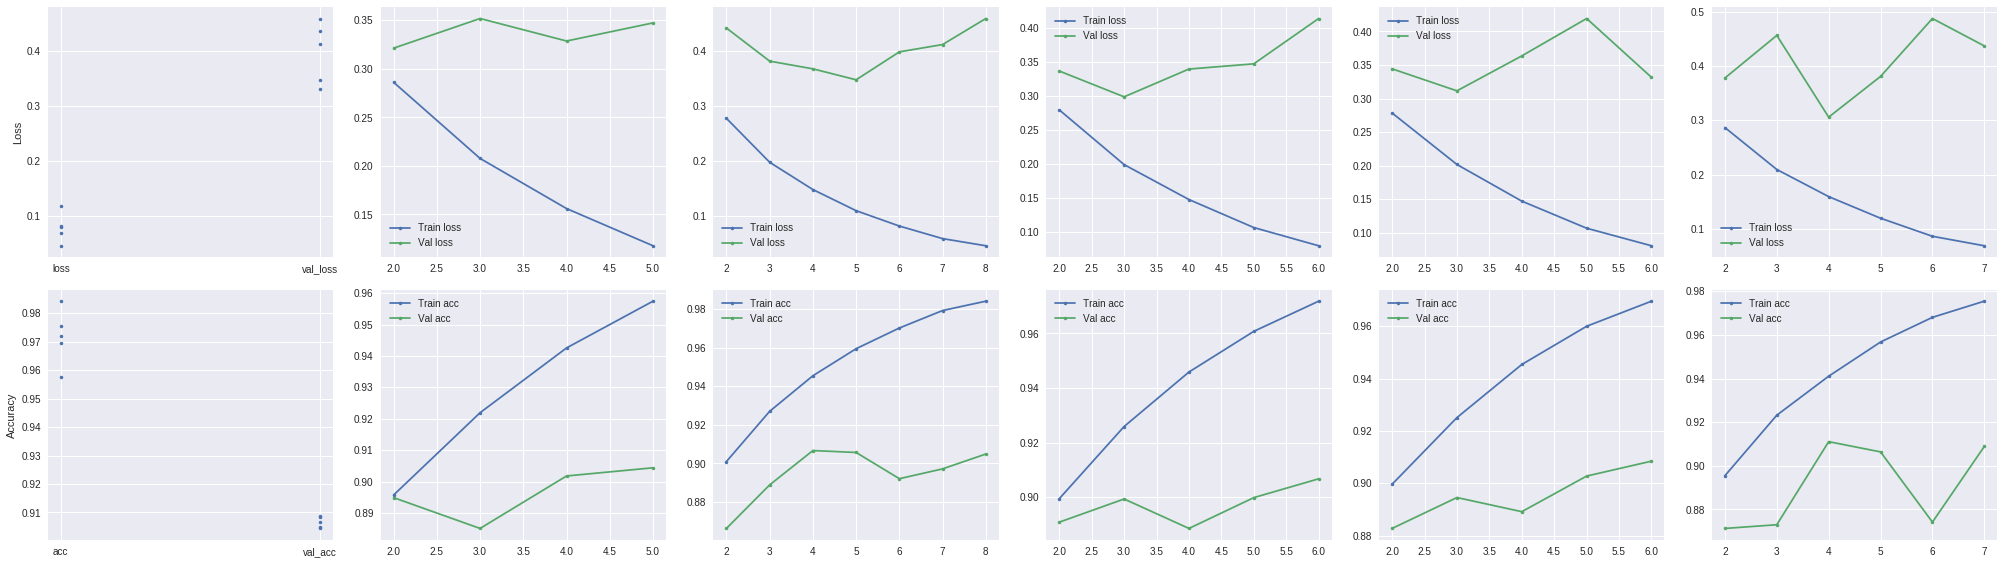

In [53]:
# 3 layers of Conv2D with increasing kernel size
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 10
Add Dropout layers to reduce overfitting 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_66 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_67 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_68 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 19, 32)        0         
__________

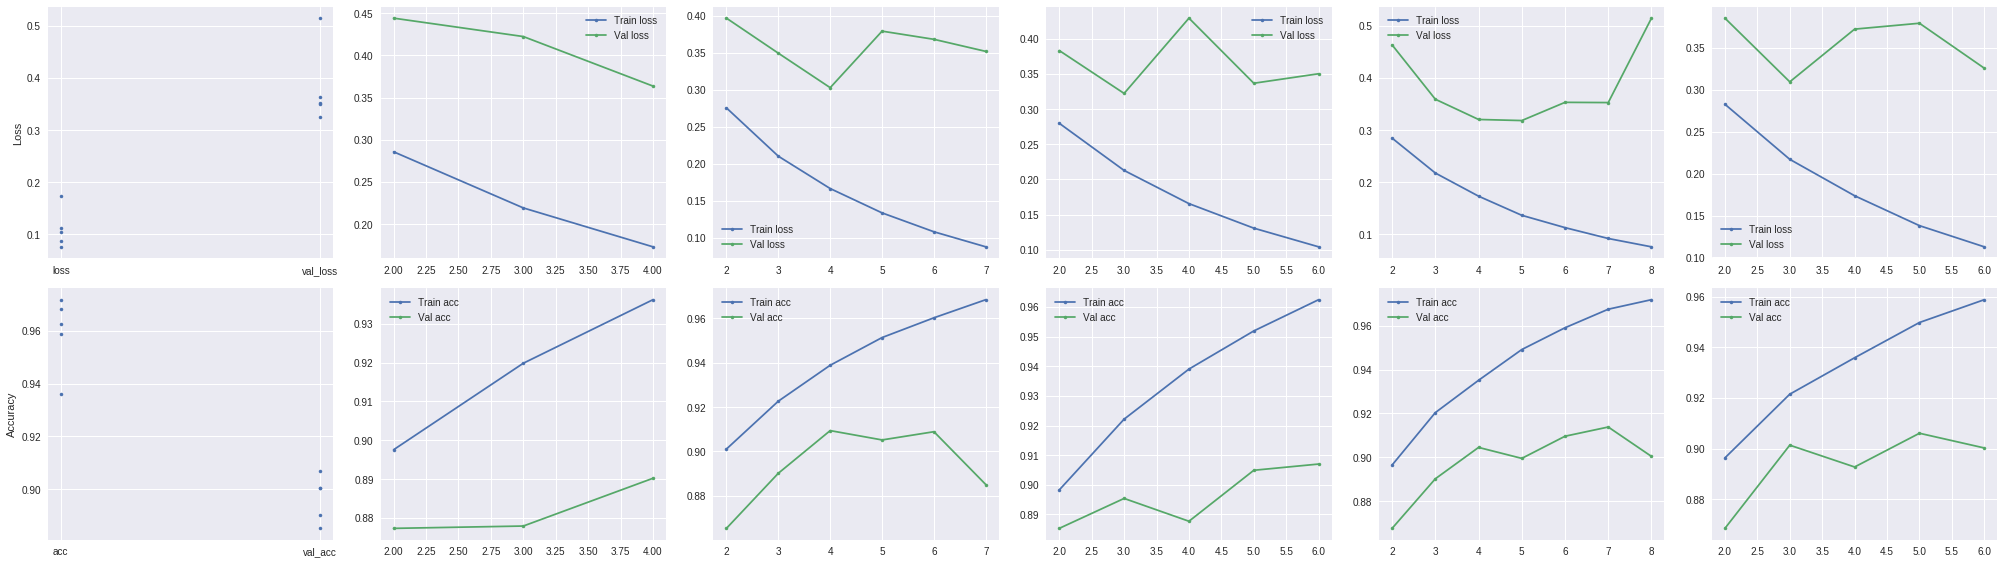

In [54]:
# Add Dropout
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 11
Add more Conv2D

In [0]:
# More Conv2D
%%time
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)

### Trial 12
Use SeparableConv2D



In [0]:
# Add Dropout
%%time
model = Sequential()
model.add(SeparableConv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

hists = train(model)